***An Object-oriented Python optimizer used for linac optimization together with ASTRA and IMPACT-T***

----
# Definition of the optimization problem

$$Minimize \; f(\mathbf{x}), \; \mathbf{x} = (x_1,...,x_n),$$
where
$$x_{j,\,l} <= x_j <= x_{j,\,u}, \; i \in \{1,...,n\}$$
with
$$g_i(\mathbf{x})<=0, \; i \in \{1, ...,m\}.$$



----
# System requirements:

- Linux (Ubuntu 14.04, 16.04)
- Python2 > 2.7.6
- [NumPy](http://www.numpy.org/), [Pandas](http://pandas.pydata.org/), [Scipy](https://www.scipy.org/scipylib/index.html)
- [matplotlib](http://matplotlib.org/)(only for visualization)
- [pyOpt](http://www.pyopt.org/)
- [ASTRA](http://www.desy.de/~mpyflo/)
- [IMPACT-T](http://portal.nersc.gov/project/m669/IMPACT-T/)

**Note**
- Do not use very deep directory to run the simulation. Otherwise the name of the output file may be truncated! (This seems to be a problem with FORTRAN)

**Windows**
- Download and install [Anaconda Python](https://www.continuum.io/downloads).
- Install pyOpt
- Download LinacOpt
```
  git clone http://github.com/zhujun98/LinacOpt.git
```
- Set your system environment
```  
  export PYTHONPATH=your/path/for/LinacOpt/
```

**Linux**

**MacOS**

----
# Modified pyOpt (not mandatory)
**alpso.py** - Location in the original package: _pyopt/pyOpt/pyALPSO/alpso.py_

The new file will let you know why the optimization converges and print out the value of the augmented Lagrangian term.

----
# Optimizers

Global optimizers: [ALPSO](http://www.pyopt.org/reference/optimizers.alpso.html#module-pyALPSO) and [NSGA2](http://www.pyopt.org/reference/optimizers.nsga2.html#module-pyNSGA2)

Local search optimizers: [SDPEN](http://www.pyopt.org/reference/optimizers.sdpen.html#module-pySDPEN)

- **ALPSO** has been proved to be a good global optimizer for the linac optimization. My experience is that it is faster than NSGA2. However, I have not tested NSGA2 very much. 

    Tips for ALPSO optimizer:

 - Convergence condition:
```
    if (abs(global_distance[0]-global_distance[stopIters-1]) <= \
      dtol*abs(global_distance[stopIters-1]) and \
      abs(global_L[0]-global_L[stopIters-1]) <= \
      rtol*abs(global_L[stopIters-1]) or \
      abs(global_L[0]-global_L[stopIters-1]) <= atol):
      stop_criteria_flag = 1
```
    If the objective is a small number, one must change 'atol' otherwise the optimization will stop prematurely.

 - 'dynInnerIter' must be set to 1 in order to make minInnerIter take effect!

----
# Examples

  Three examples are included in the current release: astra_basic, astra_advanced, impact_basic. For advanced setups please refer to examples/astra_advanced.py

## Steps for running a simple optimization.

### Step 0: Prepare the input file template

Replace the to-be-optimized value in the input template file with `<name>`.
```
    File_Bfield(1) = 'sole_gun.dat', S_pos(1) = 0.28
    S_smooth(1) = 5  
    MaxB(1) = <main_sole_b>
```

### Step 1: Assign system path and import modules

In [1]:
import sys
import os
sys.path.append(os.path.expanduser('~') + "/myscripts/linac_opt/")

from linac_opt import LinacOpt

### Step 2: Instantiate the optimization

In [2]:
opt_test = LinacOpt(path_name='examples/astra_basic',
                    input_file='injector.in',
                    input_template='injector.in.000',
                    particle_type='astra',
                    prob_name='opt_test')

### Step 3: Set up the optimizer

In [3]:
opt_test.set_optimizer('sdpen')
opt_test.optimizer.setOption('alfa_stop', 1e-2)
opt_test.optimizer.setOption('iprint', 0)
opt_test.optimizer.setOption('nf_max', 5000)

### Step 4: Set fit-points

In [4]:
opt_test.fit_points.set_point('out', 'injector.0600.001')

### Step 5: Set objective

In [5]:
def f1(fits):
    print "Horizontal emittance: {:.4f} um".format(fits.out.emitx*1.e6)
    return fits.out.emitx*1.e6
opt_test.opt_prob.set_obj('emitx_um', f1)

### Step 6: Set constraint

In [6]:
def g1(fits):
    return fits.out.n0
opt_test.opt_prob.set_con('npar', g1, equal=500)

### Step 7: Set variables


In [7]:
opt_test.opt_prob.set_var('laser_spot', value=0.1, lower=0.04, upper=0.2)
opt_test.opt_prob.set_var('main_sole_b', value=0.2, lower=0.0, upper=0.4)

### Step 8: Run the optimization


In [8]:
opt_test.solve('mpirun -np 2 astra_r62_Linux_x86_64_OpenMPI_1.6.1')

File removed: opt_test.log.000

********************************************************************************
Start solving the following problem with pyOpt.SDPEN on 
mpirun -np 2 astra_r62_Linux_x86_64_OpenMPI_1.6.1 /home/jun/myscripts/linac_opt/examples/astra_basic/injector.in
********************************************************************************

Optimization Problem -- opt_test-2017-02-03-17-20-39

Objectives:
  Name                Value        Optimum      Function        
  emitx_um             0.0000e+00  -1.0000e+21  f1              

Constraints:
  Name                Value        Bound                                           
  npar                 0.0000e+00  5.0000e+02 - 0.0000e+00 <= g1() <= 5.0000e+02 + 0.0000e+00

Variables (c - continuous, i - integer, d - discrete):
  Name                Type    Value        Lower Bound  Upper Bound
  laser_spot          c        1.0000e-01   4.0000e-02   2.0000e-01
  main_sole_b         c        2.0000e-01   0.0000e+00 

----
# Output

**General output:**
- prob_name.log.???: History of the optimization. ??? is the No. of step.
- prob_name.sol.???: Summary of the solution.
- prob_name.sol.???.pkl: Pickle file used for starting from a intermediate step.
- input_file: The input file will be filled with the optimized parameters.

**Output from specific optimizers:**
- ALPSO: ALPSO_print.out
- SDPEN: SDPEN.out.???

----
# Tips

- Be careful about the number of grids (e.g. nrad and nlong_in in ASTRA)!!! For example, when you are optimizing the emittance of a gun, the optimizer may go over the working point with a very small laser spot size. If the number of grids is too small, it may underestimate the space-charge effects. However, the thermal emittance decreases as the laser spot size decreases. Therefore, if you do not have enough grids, you may get the wrong result in this case. My experience is that the longitudinal grid number is more important.

- The parallel version of ASTRA will be stuck at some crazy working points where a lot of particles are lost. I set a 'time_out' parameter which will kill the simulation after a certain time (the optimization will continue). The default value of 'time_out' is 1200 s.

----
# Visualization

In [3]:
from beam_plots import PhaseSpacePlot

# Instantiate a PhaseSpacePlot object
p1 = PhaseSpacePlot('injector.0400.001', 'astra')

## Print the parameters

In [4]:
print p1

n                   charge (C)          p                   I_peak (A)      
      5.0000e+02          2.0000e-11          1.0020e+02          2.8452e+00

emitx (m)           emity (m)           Sx (m)              Sy (m)          
      2.5148e-07          2.5152e-07          3.7387e-04          3.7352e-04

betax (m)           betay (m)           alphax              alphay          
      5.6541e+01          5.6385e+01         -3.3015e+01         -3.2917e+01

St (m)              Sdelta              chirp (1/m)         Ct (s)          
      2.5080e-12          1.4587e-03         -4.7816e-01          6.6174e-26

emitx_slice (m)     emity_slice         Sdelta_slice        St_slice        
      2.1053e-07          2.1904e-07          2.5845e-05          1.9362e-13

Cx (m)              Cy (m)              Cxp (rad)           Cyp (rad)       
     -1.1242e-06          2.1906e-06         -6.7512e-07          1.2062e-06

emitx_tr (m)        emity_tr (m)        Sdelta_un       
      2.4771e

## Phase-space plot

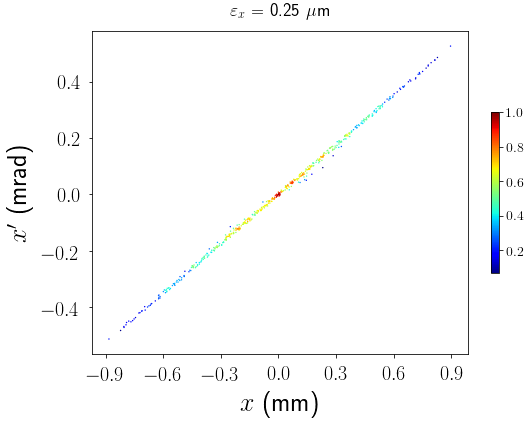

In [5]:
p1.plot('x', 'xp')

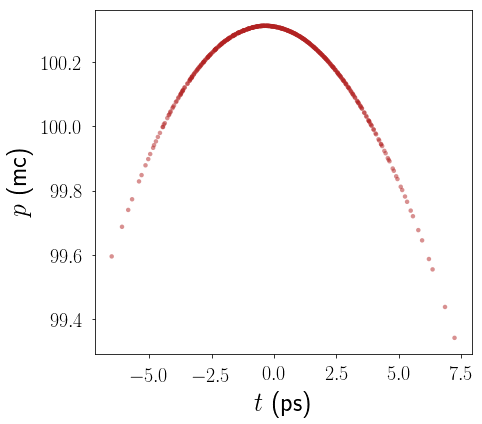

In [18]:
p1.plot('t', 'p', special=False, x_unit='ps', y1_unit='A', density_plot=False, 
        marker_color='firebrick', marker_size=20, alpha=0.5, figsize=(6.8, 6))

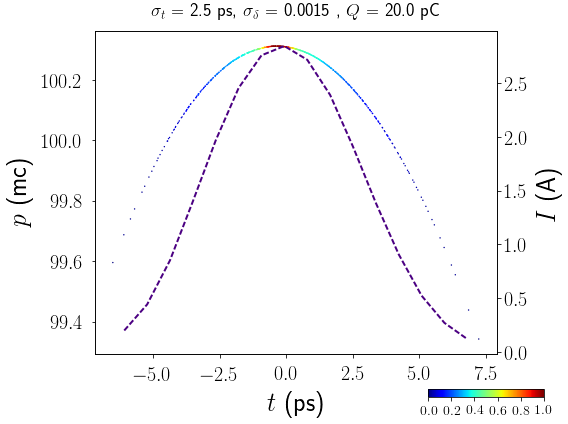

In [21]:
p1.plot('t', 'p', x_unit='ps', y1_unit='A', bins_2d=500, sigma_2d=5)

In [22]:
p1.plot('t', 'p', x_unit='ps', y1_unit='A', bins_2d=500, sigma_2d=5, output='t-p', dpi=600)

/home/jun/myscripts/linac_opt/examples/astra_basic/t-p.png generated.


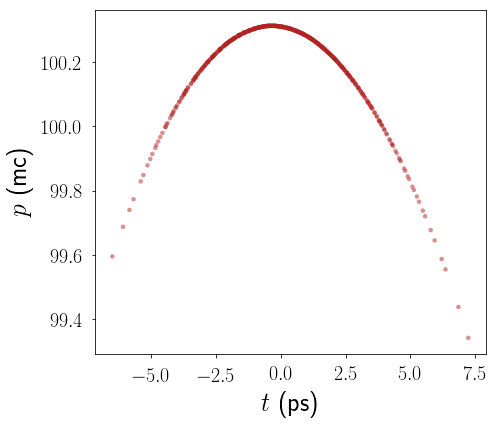

In [12]:
p1.plot('t', 'p', special=False, x_unit='ps', y1_unit='A', density_plot=False, 
        marker_color='firebrick', marker_size=20, alpha=0.5)

## Line plot

In [13]:
from beam_plots import LinePlot

# Instantiate a PhaseSpacePlot object
l1 = LinePlot('injector', 'astra')

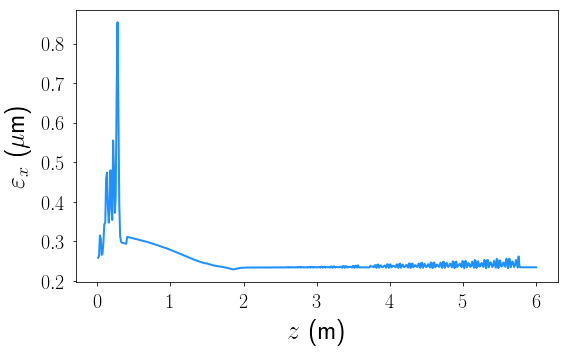

In [14]:
l1.plot('emitx')

In [15]:
l1.plot(['Sx', 'Sy'])

NameError: name 'l1' is not defined